## import 

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import matplotlib.pyplot as plt

torch.__version__    #查看cpu版本
# torch.version.cuda     #查看gpu版本

'2.2.2+cu121'

## Overfitting

out: tensor([[0.3136, 0.5338]], grad_fn=<AddmmBackward0>)
out.view(1, -1) tensor([[0.3136, 0.5338]], grad_fn=<ViewBackward0>)
fake_label: tensor([0])
Epoch 1, Loss: 0.8093137741088867
out: tensor([[ 0.7287, -0.4733]], grad_fn=<AddmmBackward0>)
out.view(1, -1) tensor([[ 0.7287, -0.4733]], grad_fn=<ViewBackward0>)
fake_label: tensor([0])
Epoch 2, Loss: 0.2628270983695984
out: tensor([[1.1742, 0.2570]], grad_fn=<AddmmBackward0>)
out.view(1, -1) tensor([[1.1742, 0.2570]], grad_fn=<ViewBackward0>)
fake_label: tensor([0])
Epoch 3, Loss: 0.3362019956111908
out: tensor([[ 1.4955, -1.0554]], grad_fn=<AddmmBackward0>)
out.view(1, -1) tensor([[ 1.4955, -1.0554]], grad_fn=<ViewBackward0>)
fake_label: tensor([0])
Epoch 4, Loss: 0.07512091845273972
out: tensor([[ 2.2471, -0.7401]], grad_fn=<AddmmBackward0>)
out.view(1, -1) tensor([[ 2.2471, -0.7401]], grad_fn=<ViewBackward0>)
fake_label: tensor([0])
Epoch 5, Loss: 0.049197956919670105
out: tensor([[ 1.1862, -1.1415]], grad_fn=<AddmmBackward0>)
out.v

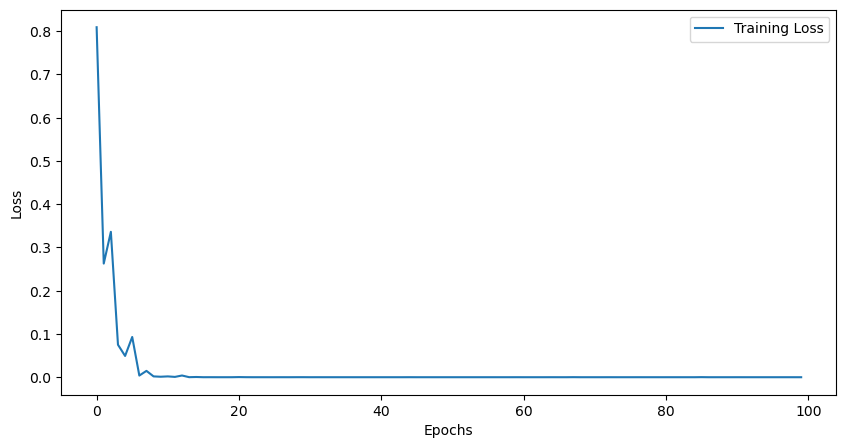

GCN(
  (conv1): GCNConv(4000, 160)
  (conv2): GCNConv(160, 160)
  (out): Linear(in_features=160, out_features=2, bias=True)
)

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
import matplotlib.pyplot as plt


class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        # 第一个GCN层
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        # 第二个GCN层
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # 全局平均池化
        # self.pool = global_mean_pool (这行不是必需的，因为我们可以直接调用global_mean_pool函数)
        # 输出层
        self.out = torch.nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 第一层GCN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # 第二层GCN
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # 使用全局平均池化获取图表示
        x = global_mean_pool(x, batch)
        # 应用最终的分类器
        x = F.dropout(x, training=self.training)
        x = self.out(x)
        return x

# 假定我们已经有了节点特征矩阵和边索引
num_nodes = 167
num_node_features = 4000
hidden_channels = 160  # 可以调节隐藏层通道数

# 创建随机的节点特征矩阵作为示例
node_features = torch.randn(num_nodes, num_node_features)

# # 需要提供图的边信息，这里我们随机生成一些边，实际情况需要根据你的图结构来定义
# edges = torch.randint(0, num_nodes, (2, num_nodes * 2), dtype=torch.long)

# 创建依次连接的边缘索引
edge_index = []
for i in range(num_nodes - 1):
    edge_index.append([i, i+1])
    # edge_index.append([i+1, i]) # 如果图是无向的，添加反方向的边

# 转换为PyTorch张量
edge_index = torch.tensor(edge_index).t().contiguous()

# 构建Data对象，包含节点特征和边信息
data = Data(x=node_features, edge_index=edge_index)

# 增加一个batch向量，这里所有的节点都来自同一个图
batch = torch.zeros(data.num_nodes, dtype=torch.long)  # 所有节点指向同一个图

# 创建模型实例
model = GCN(num_node_features=num_node_features, hidden_channels=hidden_channels)

# 假设我们在CPU上运行模型
device = torch.device('cpu')
model = model.to(device)
data = data.to(device)

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模式
model.train()

# 只有一个标签表示整个图的类别，这里随机生成一个标签作为示例
fake_label = torch.randint(0, 2, (1,), dtype=torch.long)

loss_values = []

# 训练过程
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, batch)  # 注意这里增加了batch参数
    print("out:",out)
    print("out.view(1, -1)", out.view(1, -1))
    print("fake_label:",fake_label)
    # 使用全图的标签计算损失
    loss = F.cross_entropy(out.view(1, -1), fake_label)
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# 测试模式
model.eval()


## Dataloader

In [9]:
import pandas as pd
import torch
import os

def resize_tensor(input_tensor, target_length):
    # 将输入tensor增加一个维度，变成 [batch_size, channels, length]
    input_tensor = input_tensor.unsqueeze(1)  # 现在形状为 [_, 1, _]
    
    # 使用线性插值。注意：'align_corners=False' 是默认值，
    # 它适用于大多数情况，除非你清楚需要其他行为。
    resized_tensor = F.interpolate(
        input_tensor, 
        size=target_length, 
        mode='linear', 
        align_corners=False
    )
    
    # 移除添加的通道维度，恢复原来的形状 [_, _]
    resized_tensor = resized_tensor.squeeze(1)
    
    return resized_tensor

all_data = []

# 将tensor调整为目标形状 [_, 4570]
target_length = 4570


file_folder = "/home/featurize/work/ylx/data"
# file_folder = '/home/hanghang.liu/workspace/lhh/Project/Ga-Mea/data_all/sr/'
# file_folder = '/home/hanghang.liu/workspace/lhh/Project/Ga-Mea/data_all/sac/'
# file_folder = '/home/hanghang.liu/workspace/lhh/Project/Ga-Mea/data_all/glu/'
# file_folder = '/home/hanghang.liu/workspace/lhh/Project/Ga-Mea/data_all/cnqx/'

# 获取文件夹中的所有文件名
for file_name in os.listdir(file_folder):
    data_sample = {}
    # print(file_name)
    cls_mea = file_name.split('_')[-2]
    # if cls_mea == 'baseline' or cls_mea == '3':  # phase3 and baseline
    if cls_mea == 'baseline':
        cls_lhh = 0
    else:
        # cls_lhh = int(cls_mea)  # 四分类
        cls_lhh = 1             # 二分类
    print(cls_lhh)
    
    # 假设 CSV 文件路径是 'data.csv'
    # file_path = "/home/hanghang.liu/workspace/lhh/Project/Ga-Mea/data/221213_1208_12_F50H9_Fore_baseline_spike.csv"
    file_path = os.path.join(file_folder, file_name)
    # 读取 CSV 文件
    df = pd.read_csv(file_path)
    # 转换为 NumPy 数组
    data_np = df.values
    # 转换为 torch Tensor
    data_tensor = torch.tensor(data_np, dtype=torch.float32)
    # resize
    data_tensor = resize_tensor(data_tensor, target_length)

    # 将数据添加到列表中
    data_name = file_name.split('.')[0]

    data_sample['data'] = data_tensor
    data_sample['label'] = cls_lhh
    data_sample['data_name'] = data_name
    all_data.append(data_sample)
    # print(data_tensor.shape)

print('len(all_data): ',len(all_data))

0


1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
0
1
1
1
len(all_data):  128


## FFT Dataloader

In [10]:
# import pandas as pd
# import torch
# import os
# import torch
# import torch.nn.functional as F

# def resize_tensor(input_tensor, target_length):
#     # 将输入tensor增加一个维度，变成 [batch_size, channels, length]
#     input_tensor = input_tensor.unsqueeze(1)  # 现在形状为 [_, 1, _]
    
#     # 使用线性插值。注意：'align_corners=False' 是默认值，
#     # 它适用于大多数情况，除非你清楚需要其他行为。
#     resized_tensor = F.interpolate(
#         input_tensor, 
#         size=target_length, 
#         mode='linear', 
#         align_corners=False
#     )
    
#     # 移除添加的通道维度，恢复原来的形状 [_, _]
#     resized_tensor = resized_tensor.squeeze(1)
    
#     return resized_tensor

# all_data = []

# # 将tensor调整为目标形状 [_, 4570]
# # target_length = 4570 
# target_length = 4570 // 2


# file_folder = "/home/featurize/work/ylx/data/"
# # 获取文件夹中的所有文件名
# for file_name in os.listdir(file_folder):
#     suf = file_name.split('.')[0].split('_')[-1]
#     if suf == 'Y':
#         data_sample = {}
#         # print(file_name)
#         cls_mea = file_name.split('_')[-3]
#         if cls_mea == 'baseline':
#             cls_lhh = 0
#         else:
#             # cls_lhh = int(cls_mea)  # 四分类
#             cls_lhh = 1             # 二分类
#         print(cls_lhh)
        
#         # 假设 CSV 文件路径是 'data.csv'
#         # file_path = "/home/hanghang.liu/workspace/lhh/Project/Ga-Mea/data/221213_1208_12_F50H9_Fore_baseline_spike.csv"
#         file_path = os.path.join(file_folder, file_name)
#         # 读取 CSV 文件
#         df = pd.read_csv(file_path)
#         # 转换为 NumPy 数组
#         data_np = df.values
#         # 转换为 torch Tensor
#         data_tensor = torch.tensor(data_np, dtype=torch.float32)
#         # resize
#         data_tensor = resize_tensor(data_tensor, target_length)

#         # 将数据添加到列表中
#         data_name = file_name.split('.')[0]

#         data_sample['data'] = data_tensor
#         data_sample['label'] = cls_lhh
#         data_sample['data_name'] = data_name
#         all_data.append(data_sample)
#         # print(data_tensor.shape)


# print('len(all_data): ',len(all_data))

## Train 

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt
import random


class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, out_classes):
        super(GCN, self).__init__()
        # 第一个GCN层
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        # 第二个GCN层
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # 全局平均池化
        # self.pool = global_mean_pool (这行不是必需的，因为我们可以直接调用global_mean_pool函数)
        # 输出层
        self.out = torch.nn.Linear(hidden_channels, out_classes)

    def forward(self, x, edge_index, batch):
        # 第一层GCN
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # 第二层GCN
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        # 使用全局平均池化获取图表示
        x = global_mean_pool(x, batch)
        # 应用最终的分类器
        x = F.dropout(x, training=self.training)
        x = self.out(x)
        return x

# 超参设置
num_node_features = 4570     # embedding维度
# num_node_features = 4570 // 2     # embedding维度  for fft
hidden_channels = 3000       # 可以调节隐藏层通道数
epoch = 600                 # 可以调节训练轮数
lerning_rate = 0.001         # 可以调节学习率
out_classes = 2              # 输出类别数 二分类还是四分类


# 创建多个图的数据集
num_graphs = len(all_data)   # 假设我们有100个图
graphs = []

for i in range(num_graphs):
    graph = all_data[i]
    num_nodes = int(graph['data'].shape[0])  # 每个图的节点数目
    
    node_features = graph['data']            # 节点特征矩阵
    # 创建依次连接的边缘索引
    edge_index = []
    for i in range(num_nodes - 1):
        edge_index.append([i, i+1])
    # 转换为PyTorch张量
    edge_index = torch.tensor(edge_index).t().contiguous()
    # edge_index.append([i+1, i])                      # 如果图是无向的，添加反方向的边

    y = torch.tensor([graph['label']], dtype=torch.long)
    graph_data = Data(x=node_features, edge_index=edge_index, y=y)
    graphs.append(graph_data)

random.seed(42)
# 先打乱所有的图数据
random.shuffle(graphs)

train_int = int(len(graphs) * 0.9)

# 划分训练集和测试集
train_graphs = graphs[:train_int]   # 前80%作为训练集
# test_graphs = graphs[:20]   # 后20%作为测试集
test_graphs = graphs[train_int:]    # 后20%作为测试集


# 创建DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

# 创建模型实例
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(num_node_features=num_node_features, hidden_channels=hidden_channels, out_classes=out_classes)
model = model.to(device)
# # 假设我们在CPU上运行模型
# model = model.to(device)
# data = data.to(device)
# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=lerning_rate, capturable=True)

# 设置余弦退火调整策略
# T_max 是半周期的迭代次数，eta_min 是最小学习率，默认为 0
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epoch, eta_min=0.000001)


/environment/miniconda3/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 51.90042018890381
Epoch 11, Loss: 17.406691074371338
Epoch 21, Loss: 10.965534925460815
Epoch 31, Loss: 7.504493951797485
Epoch 41, Loss: 5.239165306091309
Epoch 51, Loss: 3.911170721054077
Epoch 61, Loss: 3.2862261533737183
Epoch 71, Loss: 2.3644668459892273
Epoch 81, Loss: 1.7825789153575897
Epoch 91, Loss: 1.5552083849906921
Epoch 101, Loss: 1.5591870844364166
Epoch 111, Loss: 2.21429979801178
Epoch 121, Loss: 1.2740449905395508
Epoch 131, Loss: 0.9336527287960052
Epoch 141, Loss: 1.086742252111435
Epoch 151, Loss: 0.9484725743532181
Epoch 161, Loss: 0.9814495742321014
Epoch 171, Loss: 0.7930716872215271
Epoch 181, Loss: 0.5834170579910278
Epoch 191, Loss: 0.6347162276506424
Epoch 201, Loss: 0.9929422438144684
Epoch 211, Loss: 0.8658462464809418
Epoch 221, Loss: 0.5285403281450272
Epoch 231, Loss: 0.4439321532845497
Epoch 241, Loss: 0.39320120215415955
Epoch 251, Loss: 0.5693582445383072
Epoch 261, Loss: 0.4884849041700363
Epoch 271, Loss: 0.45338042080402374
Epoch 28

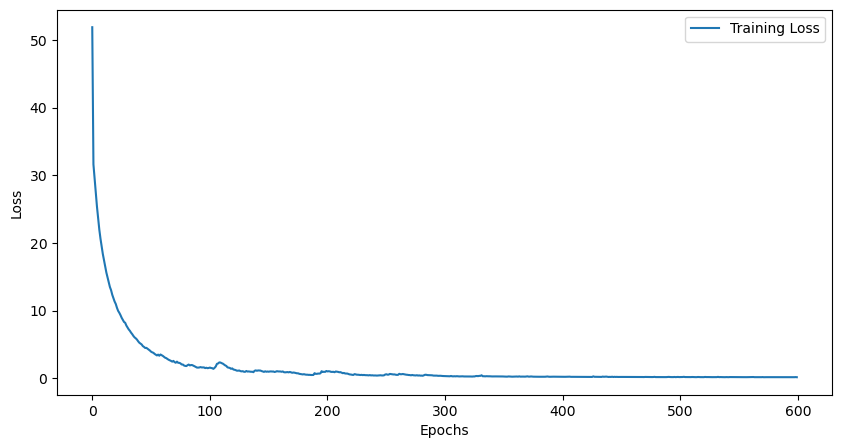

Test Accuracy: 0.8461538461538461


In [12]:
# 训练模式
model.train()

loss_values = []

# 训练过程
for epoch in range(epoch):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        
        loss = F.cross_entropy(out, data.y)

        # L1正则化项
        l1_lambda = 1e-4
        l1_norm = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)

        # 添加L1正则化
        loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 在每个epoch结束时调用scheduler.step()来更新学习率
    scheduler.step()

    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

# 训练完成后保存模型权重
model_path = f'gcn_model_ep_{epoch}_lr_{lerning_rate}_hidden_{hidden_channels}.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# 保存图像到本地文件
loss_curve_path = f'training_loss_curve_ep_{epoch}_lr_{lerning_rate}_hidden_{hidden_channels}.png'
plt.savefig(loss_curve_path)
plt.show()

# 测试模式
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
    # for data in train_loader:

        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += data.num_graphs

accuracy = correct / total
print(f'Test Accuracy: {accuracy}')



## 训练集准确率

Model loaded from gcn_model_ep_599_lr_0.001_hidden_3000.pth
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


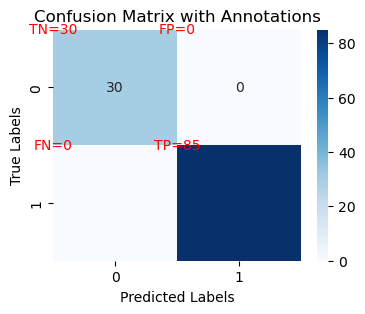

Train Accuracy: 1.0
all_labels: [1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
all_preds: [1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]


In [14]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型权重进行测试
model.load_state_dict(torch.load(model_path))
print(f'Model loaded from {model_path}')

# 收集预测和标签
all_preds = []
all_labels = []

with torch.no_grad():
    # for data in test_loader:     # 确保这里使用的是测试数据加载器
    for data in train_loader:  # 确保这里使用的是训练数据加载器

        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        all_preds.extend(pred.cpu().tolist())
        all_labels.extend(data.y.cpu().tolist())

# 计算混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_preds)

# 提取混淆矩阵的值
TN, FP, FN, TP = conf_matrix.ravel()

# 计算准确率 (Accuracy)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f'Accuracy: {accuracy:.4f}')

# 计算精确率 (Precision)
precision = TP / (TP + FP)
print(f'Precision: {precision:.4f}')

# 计算召回率 (Recall)
recall = TP / (TP + FN)
print(f'Recall: {recall:.4f}')

# 可视化混淆矩阵
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

# 标注 TP, FP, TN, FN
labels = ['TN', 'FP', 'FN', 'TP']
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{labels[i * 2 + j]}={conf_matrix[i, j]}", ha='center', va='center', color='red')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix with Annotations')
plt.show()

accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
# print(f'Test Accuracy: {accuracy}')
print(f'Train Accuracy: {accuracy}')
print(f'all_labels: {all_labels}')
print(f'all_preds: {all_preds}')

